# Introducción

Insideairbnb.com es un sitio web en el que se publican conjuntos de datos extraídos de la web de "instantáneas" de ciudades. He descargado los archivos de Ámsterdam de la situación del 6 de diciembre de 2018. Pensé que era un conjunto de datos divertido para asumir. Además de la disputa de datos básicos y las tramas, también he agregado **mapas interactivos de Folium, gráficos interactivos de tramas y extracción de texto de los comentarios de revisión.**


<br>
<center><img src="https://i.imgur.com/gEX4RCf.png"></center>
<br>


# 1. Importando módulos y datos

## 1.1 Importar módulos

In [ ]:
!pip install geopandas
!pip install chart_studio

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

## 1.2 - Usar la API de Kaggle

In [ ]:
# Instalamos la librería para manipular la API
! pip install -q kaggle

In [ ]:
# Tras hacernos un usuario en Kaggle, vamos a la sección 'account'--> 'API'
# y seleccionamos 'Create New API Token'. Subimos aquí ese fichero.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antoniozarauzmoreno","key":"2dba173b032c86154c2a2ba4f9990389"}'}

In [ ]:
# Creamos un directorio para alojar ese fichero
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Asignamos credenciales especiales para ser manipuldo por la API
! chmod 600 ~/.kaggle/kaggle.json
# Descargamos el dataset de nuestra elección
!kaggle datasets download -d erikbruin/airbnb-amsterdam
# Creamos el directorio 'input' para emular el entorno virtual de los notebooks de Kaggle
!mkdir input/
# Descomprimimos el zip en dicha carpeta
!unzip airbnb-amsterdam.zip -d input/

 98% 92.0M/93.9M [00:00<00:00, 165MB/s]
100% 93.9M/93.9M [00:00<00:00, 171MB/s]
Archive:  airbnb-amsterdam.zip
  inflating: input/calendar.csv      
  inflating: input/listings.csv      
  inflating: input/listings_details.csv  
  inflating: input/neighbourhoods.csv  
  inflating: input/neighbourhoods.geojson  
  inflating: input/reviews.csv       
  inflating: input/reviews_details.csv  


## 1.3 Detalles del listado de viviendas

El conjunto de datos contiene un total de 7 archivos. El archivo de listados es un archivo de descripción general que las etiquetas internas de airbnb como "bueno para visualizaciones". El identificador único en el conjunto de datos es la identificación de "listings". Esta es básicamente la identificación del anuncio. En general, había 20030 listados de Airbnb en Ámsterdam el 6 de diciembre de 2018.


In [ ]:
print(os.listdir("input"))

['calendar.csv', 'neighbourhoods.csv', 'listings.csv', 'reviews_details.csv', 'listings_details.csv', 'reviews.csv', 'neighbourhoods.geojson']


In [ ]:
listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews_details.csv", parse_dates=['date'])

In [ ]:
print(listings.shape)

(20030, 15)


El archivo de listados contiene 15 variables por listado además del id.

In [ ]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

El archivo listados_detalles contiene un total de 96 variables. No vamos a usar todos estos, sino que juntaremos selectivamente una serie de variables que parecen útiles para este EDA.

In [ ]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20030 entries, 2818 to 30580413
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            19992 non-null  object 
 1   host_id                         20030 non-null  int64  
 2   host_name                       20026 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   20030 non-null  object 
 5   latitude                        20030 non-null  float64
 6   longitude                       20030 non-null  float64
 7   room_type                       20030 non-null  object 
 8   price                           20030 non-null  int64  
 9   minimum_nights                  20030 non-null  int64  
 10  number_of_reviews               20030 non-null  int64  
 11  last_review                     17624 non-null  object 
 12  reviews_per_month         

Vemos que el grupo_vecindario es inútil en Ámsterdam, ya que contiene cero objetos no nulos. A continuación, nos deshacemos de esta variable y mostramos el encabezado del marco de datos con el que vamos a trabajar.

In [ ]:
listings = listings.drop(columns=['neighbourhood_group'])
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,
2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,...,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,...,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100.0,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,...,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,...,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,171,...,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


# 2. Análisis exploratorio
## 2.1 Vecindario




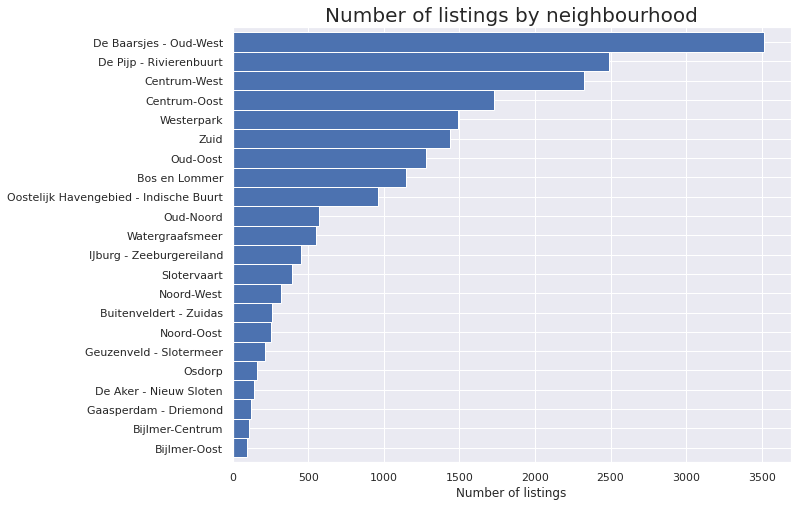

In [ ]:
feq=listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Number of listings by neighbourhood", fontsize=20)
plt.xlabel('Number of listings', fontsize=12)
plt.show()

A continuación, puede ver que la mayoría de los listados están en el centro de la ciudad. Este mapa es interactivo y puede ampliar los grupos para encontrar las ubicaciones individuales de los listados.

Nota: En una versión posterior hice un mapa sobre el precio promedio diario por barrio (sección 4.1). Creo que este mapa también sería mejor en este punto (ya que usa el archivo de forma del vecindario), pero como mi objetivo principal de este kernel es aprender tanto como sea posible, dejé el mapa a continuación sin cambios, ya que FastMarkerCluster parece útil para el futuro.

In [ ]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2.2 Tipos de propiedades y habitaciones

### 2.2.1 Tipos de habitaciones

El tipo de habitación es muy importante en Ámsterdam, porque Ámsterdam tiene la regla de que las casas/apartamentos completos solo se pueden alquilar a través de Airbnb por un máximo de 60 días al año. A continuación, podemos ver que esta restricción se aplica a la mayoría de los listados.

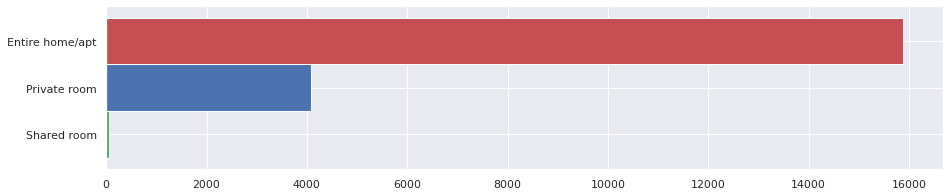

In [ ]:
freq = listings['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["g","b","r"])
plt.show()

### 2.2.2 Tipos de propiedades

En el conjunto de datos, encontramos muchos tipos de propiedades diferentes.

In [ ]:
listings.property_type.unique()

array(['Apartment', 'Townhouse', 'Houseboat', 'Bed and breakfast', 'Boat',
       'Guest suite', 'Loft', 'Serviced apartment', 'House',
       'Boutique hotel', 'Guesthouse', 'Other', 'Condominium', 'Chalet',
       'Nature lodge', 'Tiny house', 'Hotel', 'Villa', 'Cabin',
       'Lighthouse', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
       'Earth house', 'Campsite', 'Castle', 'Camper/RV', 'Barn',
       'Casa particular (Cuba)', 'Aparthotel'], dtype=object)

Sin embargo, muchos de esos tipos de propiedades tienen muy pocos listados en Ámsterdam. En la figura a continuación, solo mostramos tipos de propiedades con al menos 100 listados. Como podemos ver, la gran mayoría de las propiedades en Ámsterdam son apartamentos.

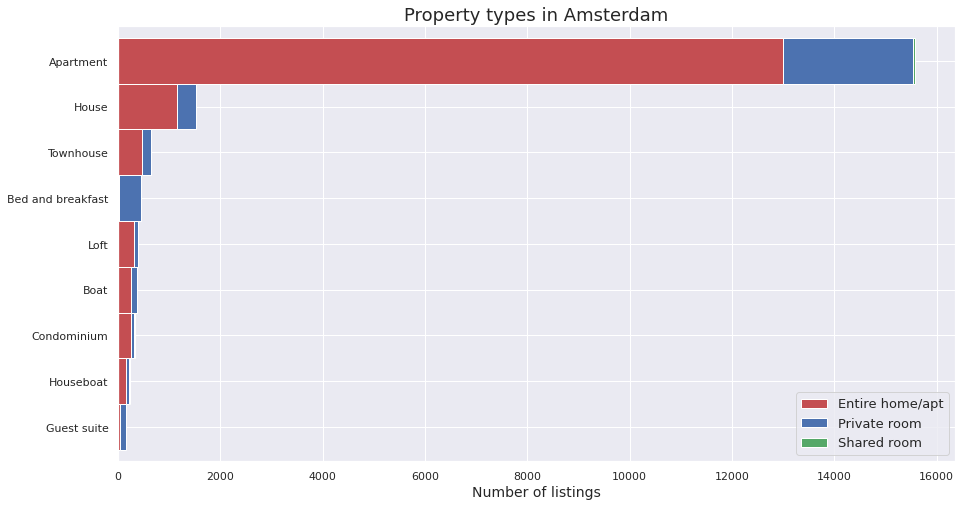

In [ ]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["r","b","g"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

## 2.3 Número de alojados

Como era de esperar, la mayoría de los listados son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio.

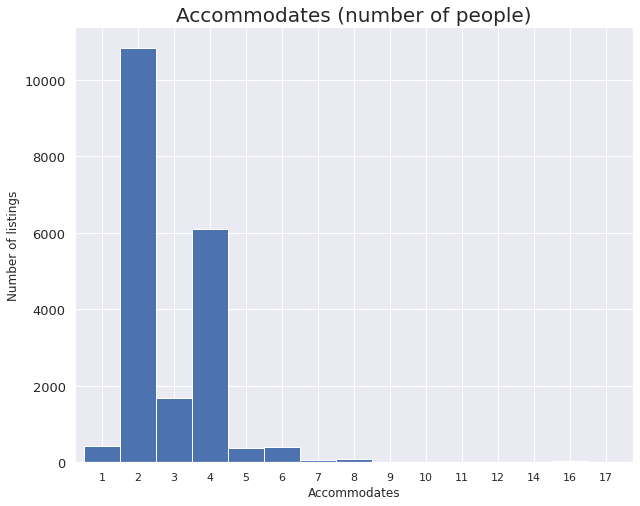

In [ ]:
feq=listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10, 8), color='b', width=1, rot=0)
plt.title("Accommodates (number of people)", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

Sin embargo, Ámsterdam tiene una restricción adicional. Debido a las consideraciones de riesgo de incendio y también teniendo en cuenta un posible grupo ruidoso, los propietarios solo pueden alquilar su propiedad a grupos con un máximo de 4 personas. ¡Esto realmente significa que las listas que indican que el número máximo de personas es superior a 4 están infringiendo esta regla!

# 3. Analítica al servicio del gobierno

Se sabe que Airbnb causa problemas en Ámsterdam. Estos problemas se describen bien en este artículo: [Fed Up With Tourists, Amsterdam Gets Tough On Airbnb, Tourist Taxes And Too Much Partying](https://www.forbes.com/sites/ceciliarodriguez/2018/05/17/amsterdam-overwhelmed-by-tourists-gets-tough-on-airbnb-tourists-taxes-too-much-partying/#5c6c78892be5

>La coalición de partidos que forman el nuevo gobierno de la ciudad quiere seguir los ejemplos de Barcelona y Venecia, donde la avalancha de turismo indisciplinado ha hecho la vida extremadamente desagradable para los residentes, obligando a las autoridades a tratar de controlar el número de visitantes y su comportamiento.

Las reglas adicionales que tiene Ámsterdam en comparación con las propias reglas de Airbnb son:

* El número máximo de invitados es de 4 (ver también apartado anterior)
* El número máximo para el alquiler a corto plazo es de 60 días por año calendario. Esta regla es solo para el alquiler de propiedades completas y, por lo tanto, no se aplica al alquiler de habitaciones privadas. Esta regla ya fue implementada por Airbnb (después de 60 días de reservas, Airbnb cierra la disponibilidad del listado por el resto del año). Como se puede leer en el artículo, el número se reducirá a un máximo de 30 días al año.
* Amsterdam tiene la intención de prohibir Airbnb por completo en tres barrios: de Wallen (Distrito Rojo), Kinkerbuurt y Haarlemmerbuurt
* Para el alquiler de Habitaciones Privadas, también existe la restricción de que un propietario no puede alquilar habitaciones que acumulen más del 40% de la superficie total (en metros cuadrados)


## 3.1 Encontrando potenciales hoteles ilegales

Cualquier propietario que alquile más del 40% de su propiedad como Habitaciones Privadas está incumpliendo la última regla mencionada en la sección anterior, pero en esta sección solo voy a buscar casos extremos.

A continuación, mostramos los cinco anfitriones que tienen la mayor cantidad de listas de salas privadas. Desafortunadamente, Airbnb no proporciona las direcciones de los listados. El campo "calle" está en realidad en la base de datos, pero como puede ver, ¡estas ciertamente no son direcciones reales completas! Por lo tanto, a partir de esta tabla no podemos decir si estos listados son de hecho en la misma casa.

In [ ]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,street,private_rooms
2436,67005410,Feliciano,"Amsterdam, Noord-Holland, Netherlands",15
918,10076897,Geraldine,"Amsterdam, Noord-Holland, Netherlands",13
2113,44168250,Ruben,"Amsterdam, Noord-Holland, Netherlands",13
1570,22879651,Wamme,"Amsterdam, Noord-Holland, Netherlands",7
3209,174174070,Amrath,"Badhoevedorp, Badhoevedorp, Netherlands",7


Sin embargo, tenemos las coordenadas GPS de los listados. Por ello, parece muy probable que todas las habitaciones privadas que ofrece Feliciano estén en el mismo edificio (solo variaciones menores en latitud/longitud). Aunque este anfitrión podría tener una licencia de hotel, sus listados también parecen sospechosos (¿cuál es el nombre del hotel?). Aconsejaría al municipio de Amsterdam que compruebe si no se infringen las normas en este caso.

In [ ]:
feliciano = private[private['host_id']== 67005410]
feliciano = feliciano[['name','host_id', 'host_name', 'latitude', 'longitude']]
feliciano.index.name = "listing_id"
feliciano

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
12392592,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375251,4.900321
12444222,Hotel in the heart of Amsterdam 4p,67005410,Feliciano,52.375130,4.899694
12446710,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.374695,4.900266
12451293,"Hotel in the heart of Amsterdam, Single room",67005410,Feliciano,52.374682,4.898916
12579177,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.374567,4.898310
12582071,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.373407,4.900022
12865293,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375077,4.900191
12865495,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.373396,4.898427
12898673,Hotel in the heart of Amsterdam 1p,67005410,Feliciano,52.373346,4.898344


## 3.2 Efectos no deseados de los anfitriones profesionales?

Por el momento, Amsterdam no tiene ninguna regla vigente para impedir las actividades de alojamiento profesional. Puedo imaginar que tener la opción de subcontratar estas actividades lleva a más listados. Por el momento, alrededor del 75% de los anfitriones solo tienen un listado. Supondremos que los anfitriones con solo un par de listados probablemente también sean anfitriones de un par de amigos. Sin embargo, vemos que hay casos extremos. Parece poco probable que los anfitriones con más de 10 listados solo hagan esto para ellos y sus amigos y familiares.

In [ ]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,19,21,24,25,27,30,38,83,105,208
count,15830,1104,174,50,37,24,9,6,4,3,...,2,2,1,1,1,1,1,1,1,1


A continuación, mostramos los anfitriones con más de 20 listados. Desafortunadamente, host_about no se raspa completamente. Sin embargo, como este conjunto de datos es extremadamente reciente, no fue difícil para mí encontrar la descripción del host con más de 200 listados en airbnb.com. Como puede ver, ¡este anfitrión es claramente un anfitrión profesional!

Como probablemente sea difícil implementar y controlar una medida que prohíba por completo las actividades de alojamiento profesional, recomendaría al municipio de Ámsterdam que considerara establecer un número máximo de listados por host. Si Amsterdam estableciera esto en, por ejemplo, 10 (y logra que esto se implemente en los sistemas de Airbnb), sería mucho más difícil explotar el hospedaje en Airbnb como una actividad profesional.

In [ ]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
8166,65859990,Martijn,"Hi, I'm Martijn, \r\n\r\nWe are a team of prof...",208
535,1464510,Michiel And Jane,"Hi, we are Michiel & Jane,\r\n\r\nWe are a tea...",105
8999,113977564,Willem,I own a hotel in Amsterdam and manage properti...,38
190,517215,Niels En Viv (Welcome Back),"Hi travellers, \r\n\r\nWe are Welcome Back, a ...",30
4935,14183886,Luis,We are Luis and Melanie and we managed our own...,25
4531,11969034,Raul,"Dear Guests,\r\n\r\nI'm Raul, 35 years old. I ...",24
7456,44168250,Ruben,Running a family business in real estate & tou...,21
3457,7594884,"Ruben, Sarah & Lindy","We are Ruben, Sarah & Lindy, we rent out prope...",21


Hosted by Martijn

Amsterdam, Netherlands · Joined in April 2016

Martijn User Profile: 1928 Reviews, Verified

_Hi, I'm Martijn, We are a team of professional hosts established by travelers just like you. We believe in sharing homes. Wherever you are, it is delightful to explore and discover an unknown city from an authentic home. On behalf of home owners we advertise their properties through our airbnb profile and support them by offering you a pleasant stay. When you book your holiday with us, you can be confident of a memorable stay and an experience through the eyes of a local. We are more than happy to share our knowledge, give you the best insider tips and recommendations about Amsterdam. If you have any questions, holiday wishes or simply want to have a chat, then feel free to contact us any time. We always reply within an hour! We look forward to being your host! :)_

# 4. Consejos al turismo

## 4.1 Precio medio por vecindario

Para comparar "manzanas con manzanas" solo seleccionaremos el tipo de alojamiento más común, que es el alojamiento para 2 personas. Como era de esperar, el alojamiento en el centro de la ciudad es el más caro.

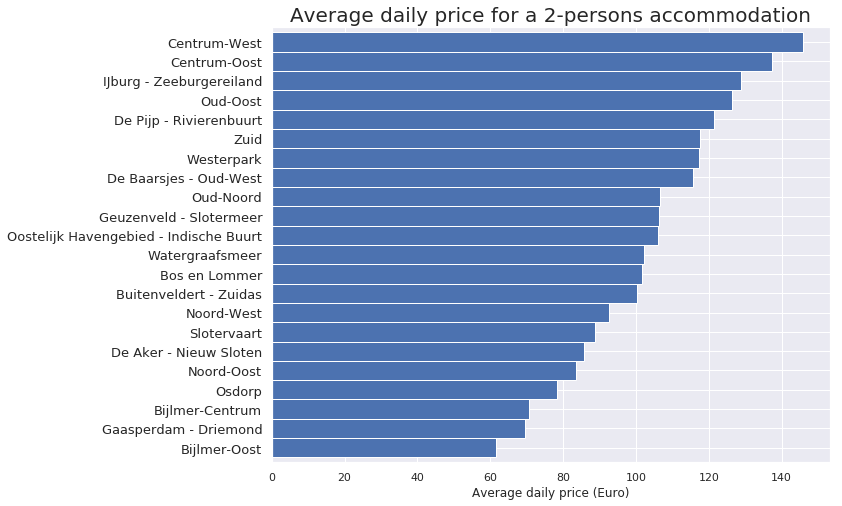

In [ ]:
feq = listings[listings['accommodates']==2]
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq.plot.barh(figsize=(10, 8), color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("")
plt.show()

A continuación puede encontrar los barrios en un mapa. Este mapa es **interactivo**. Al pasar el cursor sobre los polígonos se muestra el nombre del barrio y el precio medio de los alojamientos para 2 personas.

In [ ]:
adam = gpd.read_file("../input/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

## 4.2 Seguridad del vecindario

Como no hay datos sobre la seguridad del vecindario en los archivos de Airbnb, en `imgur` se pueden encontrar datos adicionales a este respecto. Como puedes ver, hoy en día las partes occidentales de la ciudad son las más peligrosas.


<center><img src="https://i.imgur.com/7cso9GD.png" style="width: 800px;"/></center>

## 4.3 Review scores location, and location scores versus price

En esta sección, agrupamos los puntajes de revisión de la ubicación por vecindario (solo listados con al menos 10 revisiones). Aunque esperamos que la distancia al centro de la ciudad sea un factor importante, esta puntuación también debería tener en cuenta otras cosas. Otros factores pueden incluir:

* La seguridad de una ubicación (como se muestra en la sección anterior)
* Ruido. Si una lista tiene una ubicación central, pero está rodeada de bares ruidosos, eso debería costar puntos en el puntaje de revisión de la ubicación.
* Si un listado está ubicado fuera del centro de la ciudad pero bien conectado por transporte público, debería obtener puntos de bonificación por eso.
* Instalaciones cercanas al listado. ¿Hay supermercados, bares y restaurantes cerca?
* Puede que algunas personas busquen aparcamiento gratuito si vienen en coche (el aparcamiento es muy caro en Ámsterdam en general).

A continuación, vemos que los vecindarios centrales, que generalmente también fueron los más caros, generalmente también obtienen una puntuación más alta en la puntuación de revisión de ubicación. Si calculara la distancia al centro de la ciudad para cada listado, espero ver correlaciones bastante fuertes entre esta distancia con el puntaje de revisión del precio y la ubicación.

Al mirar el puntaje promedio de revisión, me sorprende ver que el promedio está por encima de 8/10 para todos los vecindarios. Ámsterdam es una ciudad pequeña (¡mucho más pequeña de lo que mucha gente piensa!). Por lo tanto, no lleva mucho tiempo llegar al centro de la ciudad desde cualquier lugar, lo que podría explicar hasta cierto punto los altos promedios. Mi consejo personal para los turistas sería considerar un alojamiento más asequible fuera del centro de la ciudad, en un vecindario seguro y con buenas conexiones de transporte público al centro de la ciudad de todos modos. Sin embargo, ¿las diferencias entre las mejores ubicaciones y los vecindarios exteriores son realmente tan pequeñas? ¡Vamos a averiguarlo en la siguiente sección!


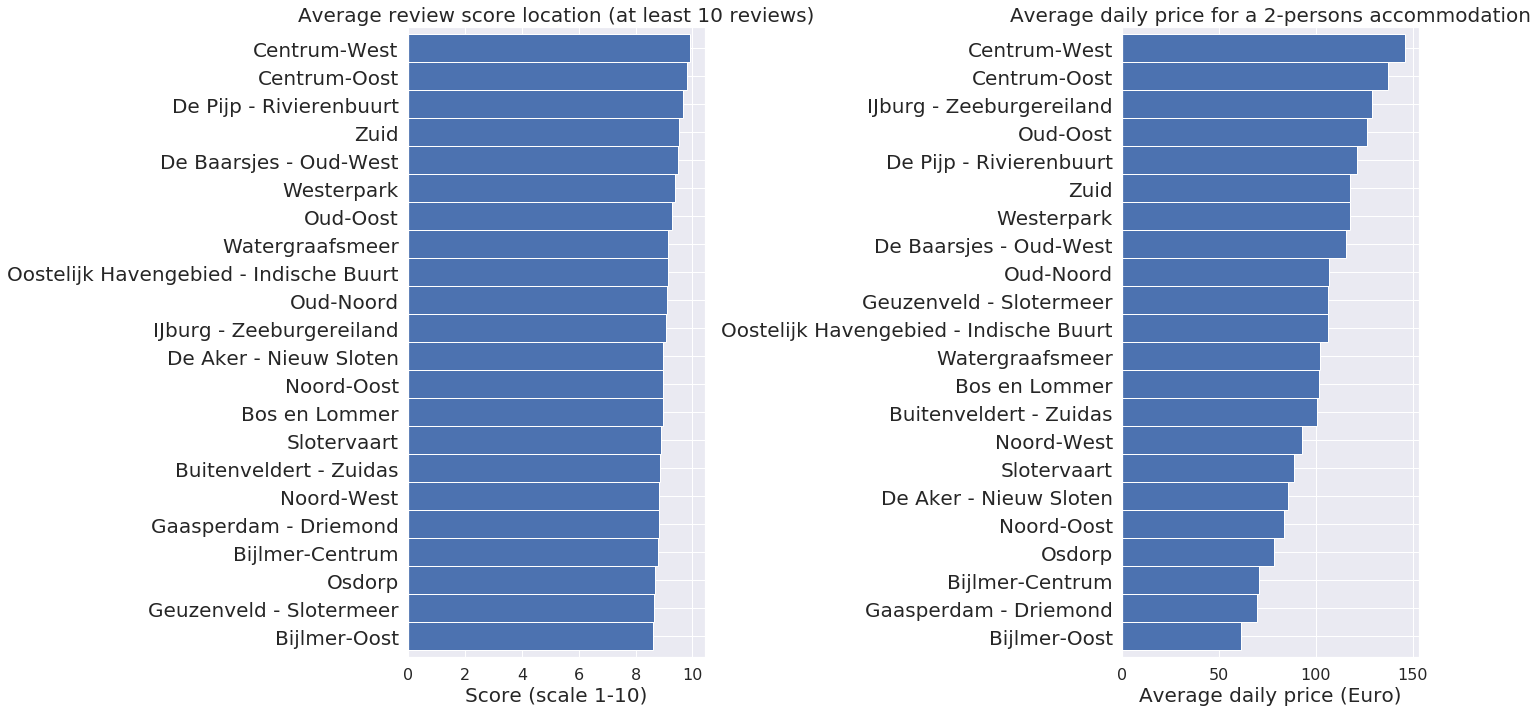

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
ax1=feq1.plot.barh(color='b', width=1)
plt.title("Average review score location (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates']==2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
ax2=feq2.plot.barh(color='b', width=1)
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show()

## 4.4 Cómo usar las puntuaciones de las opiniones

Además de las reseñas escritas, los invitados pueden enviar una calificación de estrellas general y un conjunto de calificaciones de estrellas de categoría. Los huéspedes pueden dar calificaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia en general?
* Limpieza. ¿Sentiste que tu espacio estaba limpio y ordenado?
* Precisión. ¿Con qué precisión su página de listado representó su espacio?
* Valor. ¿Sintió que su listado proporcionó un buen valor por el precio?
* Comunicación. ¿Qué tan bien se comunicó con su anfitrión antes y durante su estadía?
* Llegada. ¿Qué tan bien fue su registro?
* Ubicación. ¿Cómo te sentiste en el barrio?

A continuación puede ver la distribución de puntajes de todas esas categorías. ¡Lo que me llamó la atención de inmediato es que las puntuaciones parecen realmente altas en todos los ámbitos!. Está bien explicado en este artículo: [¿Más alta que la calificación promedio? El 95 % de los listados de Airbnb calificaron de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Después de haber visto las distribuciones de puntajes, personalmente consideraría que cualquier puntaje de 8 o inferior no es un buen puntaje.

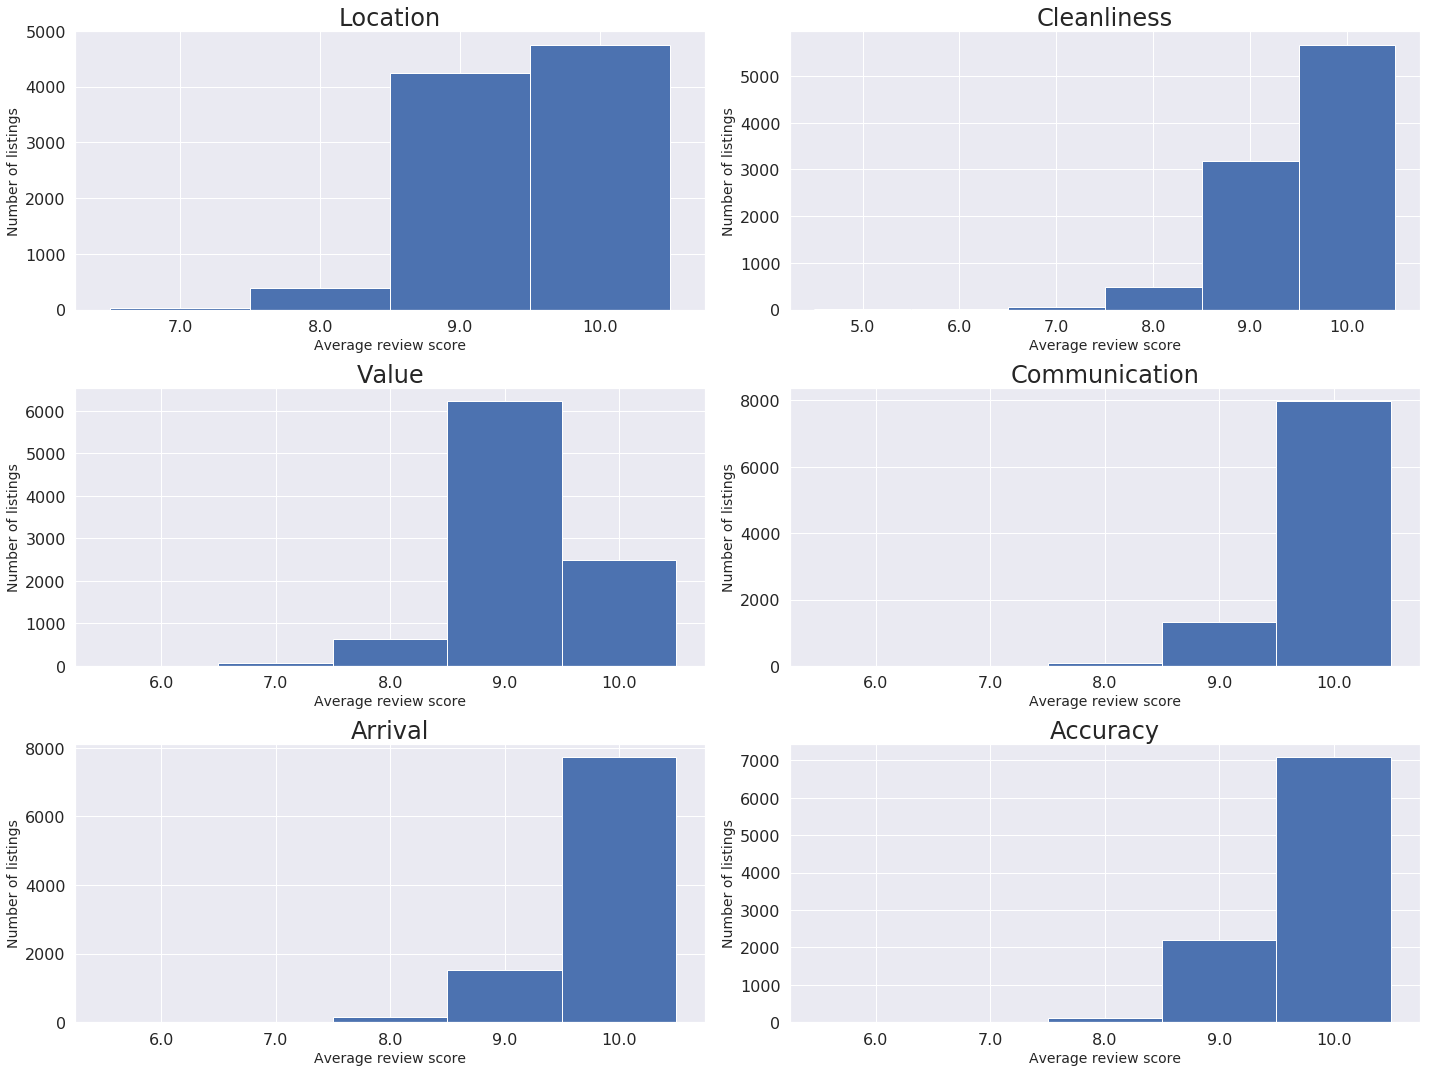

In [ ]:
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

## 4.5 Encontrando un buen hospedador

En Airbnb puedes obtener el estatus de "Superhost". De Airbnb:
* Como SuperAnfitrión, tendrá más visibilidad, potencial de ingresos y recompensas exclusivas. Es nuestra manera de decir gracias por su hospitalidad excepcional.
* Cómo convertirse en Superhost: cada 3 meses, verificamos si cumple con los siguientes criterios. Si lo haces, ganarás o mantendrás tu estatus de SuperAnfitrión.
    * Los Superanfitriones tienen una calificación general promedio de 4.8 o superior según las reseñas de al menos el 50 % de sus huéspedes de Airbnb durante el último año.
    * Los Superhosts han alojado al menos 10 estadías en el último año o, si realizan reservas a más largo plazo, 100 noches en al menos 3 estadías.
    * Los Superhosts no tienen cancelaciones en el último año, a menos que haya circunstancias atenuantes.
    * Los Superhosts responden al 90 % de los mensajes nuevos en 24 horas.

A continuación, podemos ver que solo una pequeña parte de los listados en Ámsterdam tienen un anfitrión que es Superanfitrión.

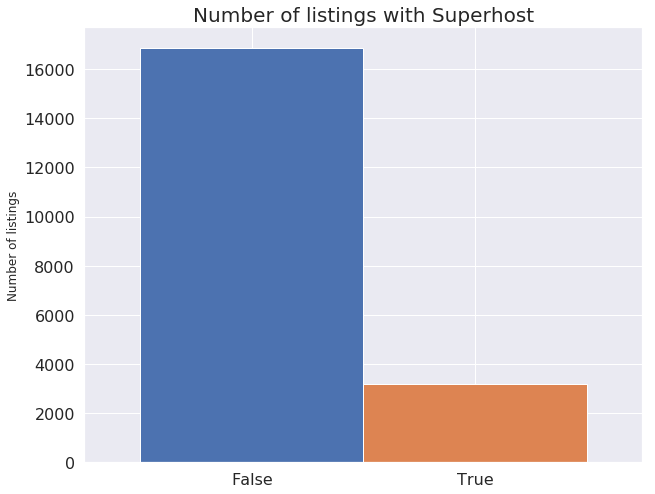

In [ ]:
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

Si tuviéramos que reservar alojamiento, no buscaríamos necesariamente un superhost. En realidad, me temo que pagaría demasiado, ya que el superhost probablemente aumentará sus precios. Sin embargo, tampoco me gustaría un host que responde mal o cancela mucho.

Como podemos ver, más de 5.000 de los 20.000 listados tienen al menos 10 reseñas y responden al menos al 90% de los mensajes nuevos. Consideraría que esos anfitriones son buenos respondedores "probados" (lo que no significa que una lista con menos de 10 reseñas no pueda tener buenos anfitriones que respondan; simplemente no está probado todavía). Además, hay muy pocos listados con anfitriones que no respondan a los mensajes nuevos dentro de las 24 horas.

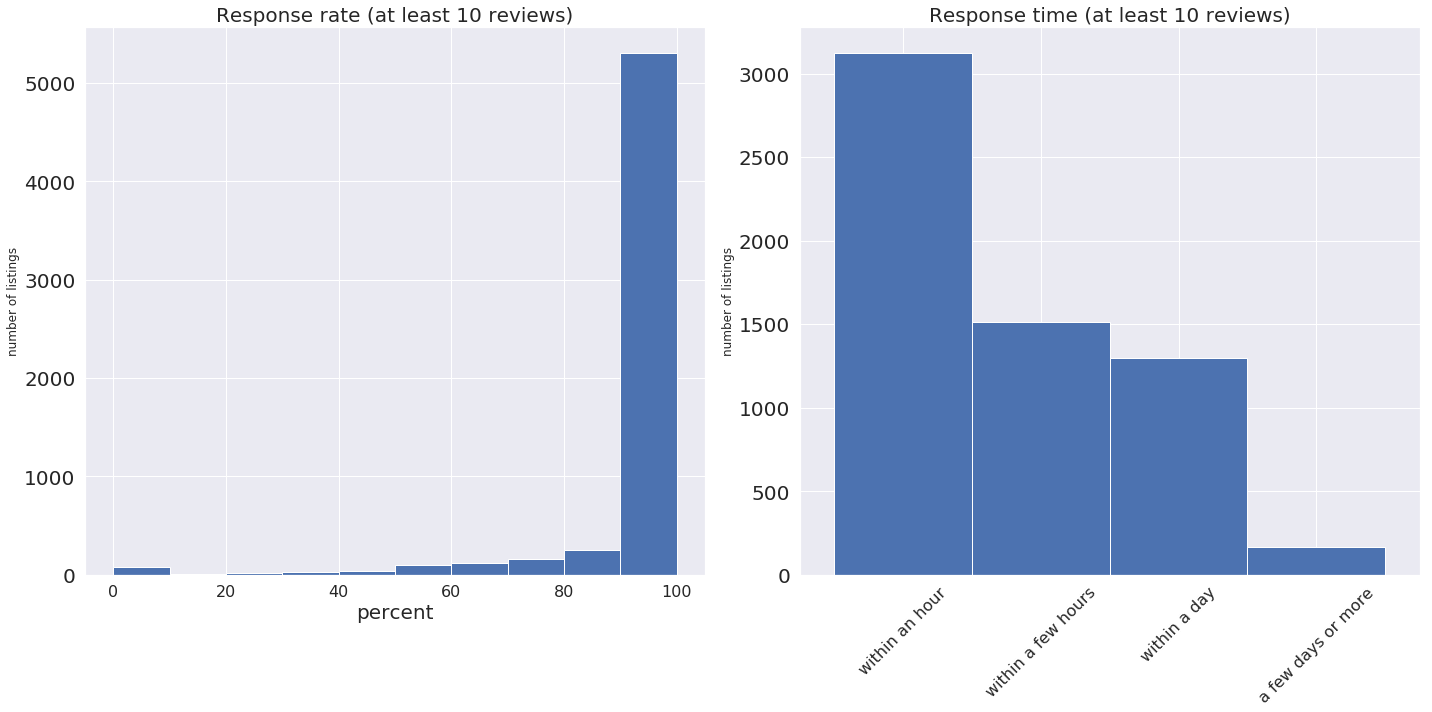

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

## 4.6 Disponibilidad en el tiempo

El archivo de calendario contiene 365 registros para cada listado, lo que significa que para cada listado, el precio y la disponibilidad por fecha se especifican con 365 días de anticipación.

In [ ]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2019-12-05']

In [ ]:
print(calendar.shape)

(7290073, 3)


A continuación se muestra un ejemplo de los datos del calendario. Importante tener en cuenta: la disponibilidad es FALSE significa que el propietario no quiere alquilar su propiedad en la fecha específica o que la lista ya se ha reservado para esa fecha. Como queremos comparar manzanas con manzanas nuevamente con respecto a los precios en la siguiente sección, estamos fusionando la variable 'accomodate' con el calendario.

In [ ]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,accommodates
listing_id,,,,
19408353,2019-05-28,f,NaN,4
8143925,2019-11-16,f,NaN,4
18790563,2019-09-01,f,NaN,4
12524110,2019-06-22,t,49.0,1
27307449,2019-04-12,f,NaN,4
6027811,2019-02-13,t,149.0,3
4605575,2019-06-25,t,175.0,4
30082467,2019-03-16,f,NaN,3
4157853,2019-11-19,t,164.0,3


A continuación, vemos que hasta tres meses por delante, generalmente hay más alojamientos disponibles que en el futuro. Las razones de esto pueden ser que los anfitriones están actualizando más activamente sus calendarios en este período de tiempo. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el "número de listados disponibles" y el "día de la semana" por fecha.

In [ ]:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date')

## 4.7 Precio medio por día

A continuación, verá el precio promedio de todos los alojamientos para 2 personas marcados como disponibles por fecha. El pico del precio promedio de 240 euros es el 31 de diciembre y el patrón cíclico se debe a precios más altos en los fines de semana. Sin embargo, sospecho que los precios para fechas más lejanas en el tiempo aún no están actualizados y probablemente sean precios predeterminados. Esto podría dar lugar a que el anfitrión no acepte una reserva si se da cuenta de que alguien está intentando reservar algo en una fecha que debería haber sido más cara de lo habitual. Este gráfico es **interactivo** y, al pasar el cursor sobre los puntos, se mostrará una información sobre herramientas con el precio promedio y el día de la semana por fecha.

In [ ]:
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date')

# 5. Minería de texto con las _reviews_ (opcional)


Veamos ahora cómo podríamos obtener algo de información extra de las opiniones de los usuarios, en términos muy elementales. Esta sección es un preliminar muy introductorio y básico de un amplio área de estudio conocida como *topic modelling*.

El archivo de "reviews" resultó no ser muy interesante, ya que solo contiene fechas de revisión para cada listado, lo que significa que solo es bueno para contar el número de revisiones. El archivo "reviews_details" contiene la misma información (y la misma cantidad de registros), con 4 columnas adicionales. Además, fusionamos host_id y host_names de la lista con el archivo reviews_details.

In [ ]:
reviews_details.shape

(431830, 6)

In [ ]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
1191,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1771,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
1989,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
2797,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
3151,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


A continuación, encontrará los 5 hosts con más reseñas. Es interesante ver de nuevo los nombres de los anfitriones Martijn y Feliciano, que ya se han discutido antes.

In [ ]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
1464510,Michiel And Jane,1772
65859990,Martijn,1407
67005410,Feliciano,1350
336950,Manuel,1154
124245,Edwin,1001


In [ ]:
reviews_details.comments.head()

id
1191    Daniel is really cool. The place was nice and ...
1771    Daniel is the most amazing host! His place is ...
1989    We had such a great time in Amsterdam. Daniel ...
2797    Very professional operation. Room is very clea...
3151    Daniel is highly recommended.  He provided all...
Name: comments, dtype: object

In [ ]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'We had such a great time in Amsterdam. Daniel is an excellent host! Very friendly and everytime helpful. The room was cozy, comfortable, and VERY clean. Maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. Bathroom with all the bathroom requires. Good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.\r\nTotally recommendable! '

Añadimos ahora algo de preprocesamiento

In [ ]:
#take out empty comments (530)
reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

'great time amsterdam daniel excellent host friendly everytime helpful room cozy comfortable clean maps towels mini fridge coffee very tasty tea supplies provided bathroom bathroom requires good location next tram stop took around minutes get city center totally recommendable '

Veamos cómo implementar un conteo de palabras y emplearlo para crear un *wordcloud*

In [ ]:
texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
51,great,203591
175,apartment,183343
53,amsterdam,171791
87,stay,164215
3,place,161435
106,us,130859
4,nice,123083
67,location,119437
26,host,102330
5,clean,94514


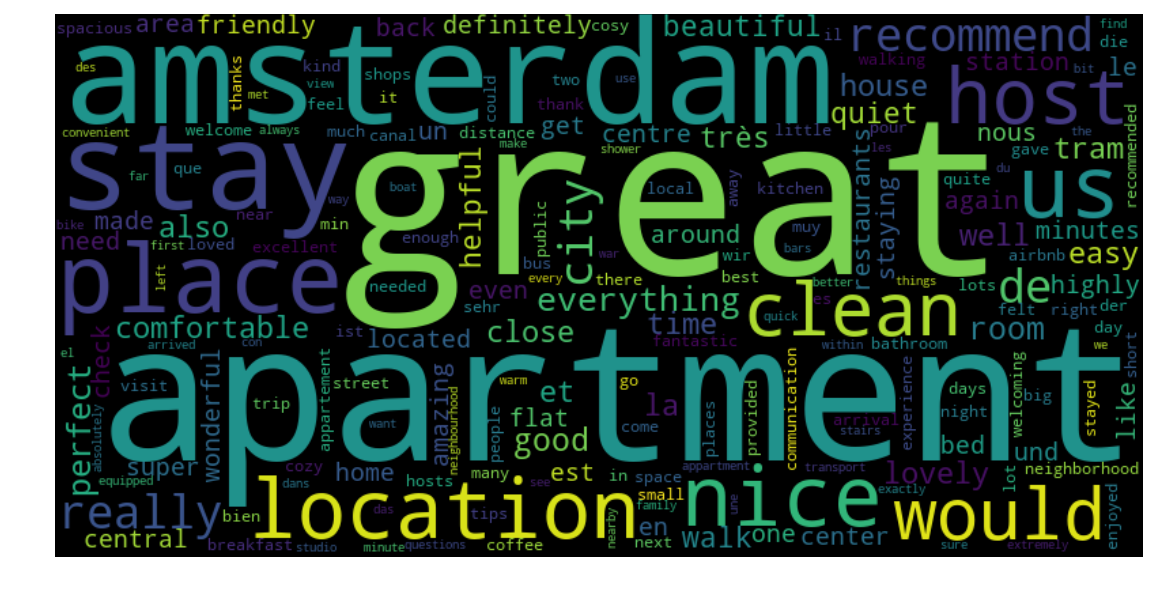

In [ ]:
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()